In [1]:
from __future__ import print_function, division
from collections import OrderedDict
import uproot
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np

%matplotlib inline
from fnal_column_analysis_tools import hist
from fnal_column_analysis_tools.hist import plot

In [2]:
import pickle, gzip

# moving numpy arrays through pickle between python 2 
# and python 3 can get a bit messed up, the following
# seems to work in most cases
import six
with gzip.open("final.pkl.gz", "rb") as fin:
    if six.PY2:
        final = pickle.load(fin)
    else:
        final = pickle.load(fin, encoding='latin1')

In [3]:
final

<Hist (dataset,gencat,doubleB,msd,ptj) instance at 0x11f9dbda0>

In [4]:
process = hist.Cat("process", "Process", sorting='placement')
process_cats = ("dataset", "gencat")
process_map = OrderedDict()
process_map["QCD in V"] = ("*", 0)
process_map["Zqq"] = ("ZJetsToQQ_HT*", 1)
process_map["Zcc"] = ("ZJetsToQQ_HT*", 2)
process_map["Zbb"] = ("ZJetsToQQ_HT*", 3)
process_map["Wqq"] = ("WJetsToQQ_HT*", 1)
process_map["Wcs"] = ("WJetsToQQ_HT*", 2)

final_mapped = final.group(process, process_cats, process_map)

In [5]:
# to_plot = final_mapped.project("doubleB", slice(0.8, 1.)).project("ptj", slice(450,600))
to_plot = final_mapped[:,0.8:,:,450:500].sum("doubleB", "ptj")
to_plot.fill(process="Sandwich", msd=np.random.normal(loc=150, scale=10, size=200), weight=np.ones(200)*.05)

bc = to_plot.sum("process").axis("msd").centers()
bv = to_plot.sum("process").values()[()]
bvp = np.random.poisson(bv)
data = np.repeat(bc, bvp)
data_plot = to_plot.copy(content=False)
data_plot.fill(process="Pseudodata", msd=data)

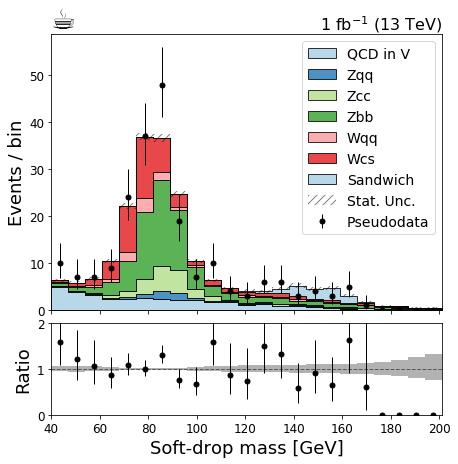

In [6]:
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})
fig, (ax, rax) = plt.subplots(2, 1, figsize=(7,7), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

# http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
ax.set_prop_cycle(cycler(color=colors))

fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label':'Stat. Unc.',
    'hatch':'///',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
    'emarker': '_'
}

plot.plot1d(to_plot, 
            overlay="process", 
            ax=ax,
            clear=False,
            stack=True, 
            line_opts=None,
            fill_opts=fill_opts,
            error_opts=error_opts
           )
plot.plot1d(data_plot,
            overlay="process",
            ax=ax,
            clear=False,
            error_opts=data_err_opts
           )

ax.autoscale(axis='x', tight=True)
ax.set_ylim(0, None)
ax.set_xlabel(None)
leg = ax.legend()

plot.plotratio(data_plot.sum("process"), to_plot.sum("process"), 
               ax=rax,
               error_opts=data_err_opts, 
               denom_fill_opts={},
               guide_opts={},
               unc='num'
              )
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

coffee = plt.text(0., 1., u"☕",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"1 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )

In [7]:
fig.savefig("fig.pdf")

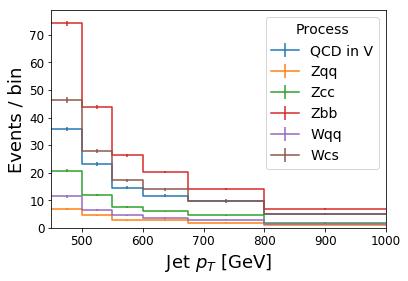

In [8]:
to_plot_2 = final_mapped[:,0.8:,:,450:].sum("doubleB", "msd")
# if no axes are passed, plot1d will create its own
fig2, ax2, _ = plot.plot1d(to_plot_2, overlay="process")

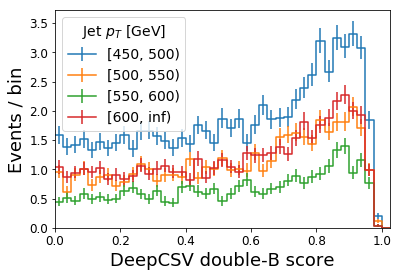

In [9]:
to_plot_2 = final_mapped["Zcc",:,:,:600].sum("msd", "process")
fig3, ax3, _ = plot.plot1d(to_plot_2, overlay="ptj", overflow='over', overlay_overflow='over')

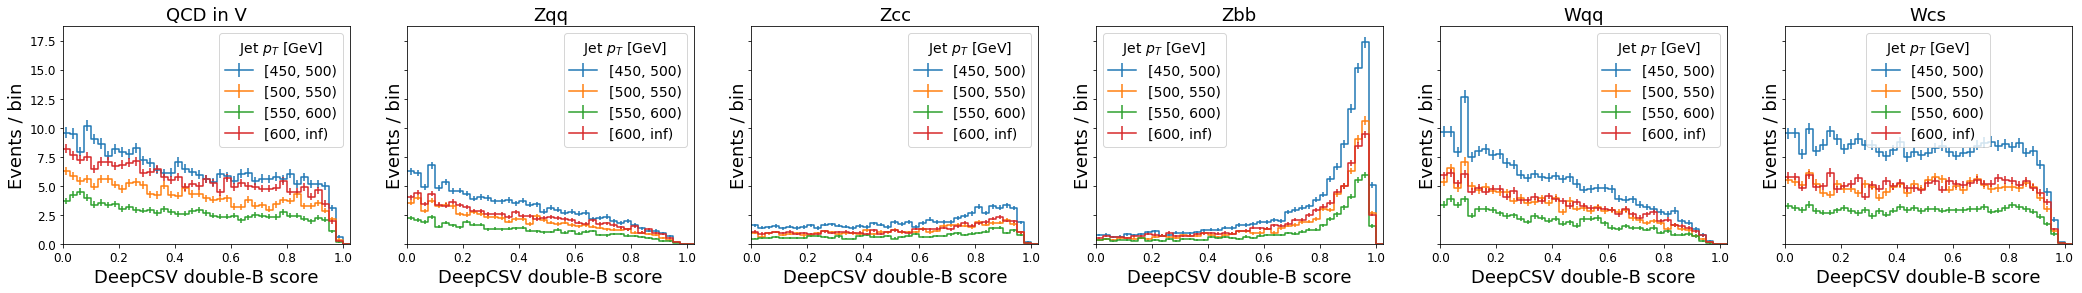

In [10]:
to_plot_3 = final_mapped[...,:600].sum("msd")
fig, axes = plot.plotgrid(to_plot_3, col="process", overlay="ptj", overflow='over', overlay_overflow='over')